--- Starting Q4: Time-Series Forecasting with SARIMA...


<ipython-input-1-5c54f51d669c>:10: DtypeWarning: Columns (77) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("airline_2m.csv", encoding="ISO-8859-1", parse_dates=["FlightDate"])


✈️ Selected Routes: ['JFK-LAX', 'SFO-LAX', 'LAX-SFO']

📈 Processing route: JFK-LAX


<ipython-input-1-5c54f51d669c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Forecast"] = forecast_values
<ipython-input-1-5c54f51d669c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["SmoothedActual"] = test["FlightCount"].rolling(window=3, center=True).mean()


📊 RMSE for JFK-LAX: 1.64 (lower is better)


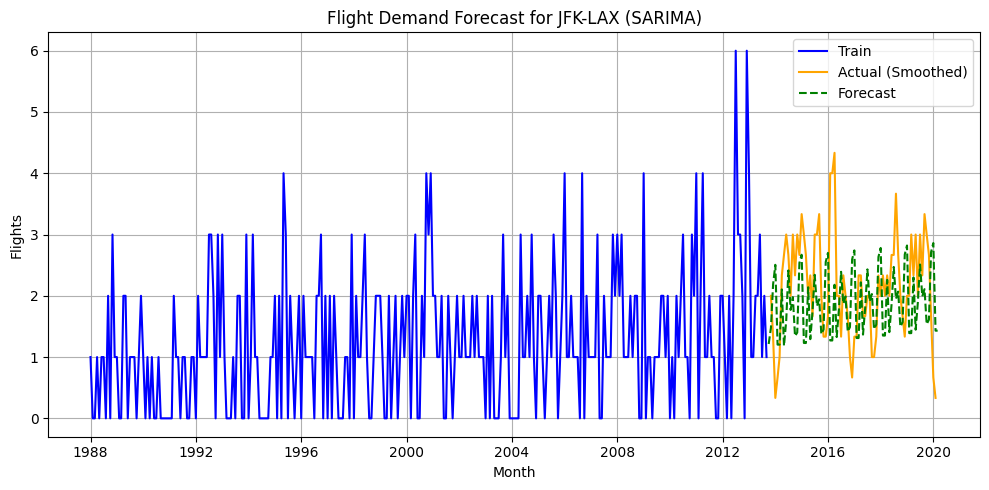


📈 Processing route: SFO-LAX


<ipython-input-1-5c54f51d669c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Forecast"] = forecast_values
<ipython-input-1-5c54f51d669c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["SmoothedActual"] = test["FlightCount"].rolling(window=3, center=True).mean()


📊 RMSE for SFO-LAX: 1.67 (lower is better)


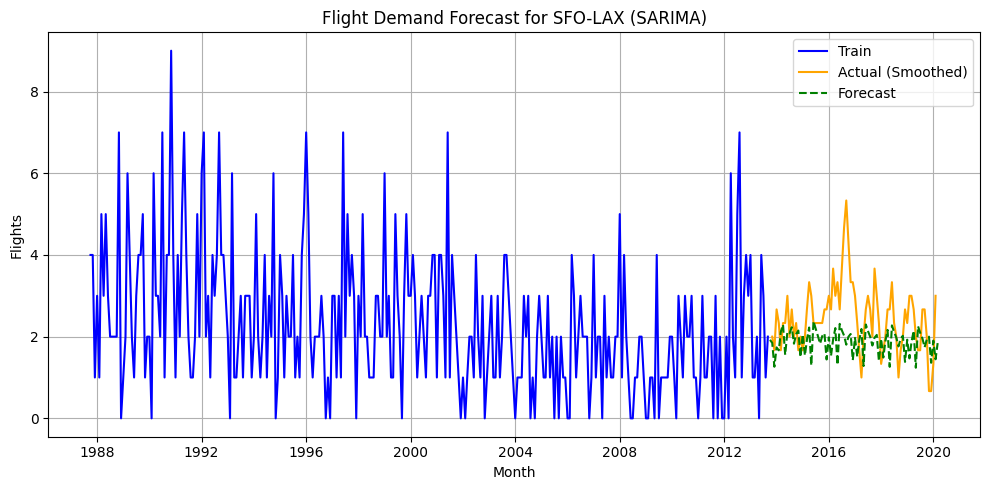


📈 Processing route: LAX-SFO


<ipython-input-1-5c54f51d669c>:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Forecast"] = forecast_values
<ipython-input-1-5c54f51d669c>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["SmoothedActual"] = test["FlightCount"].rolling(window=3, center=True).mean()


📊 RMSE for LAX-SFO: 1.62 (lower is better)


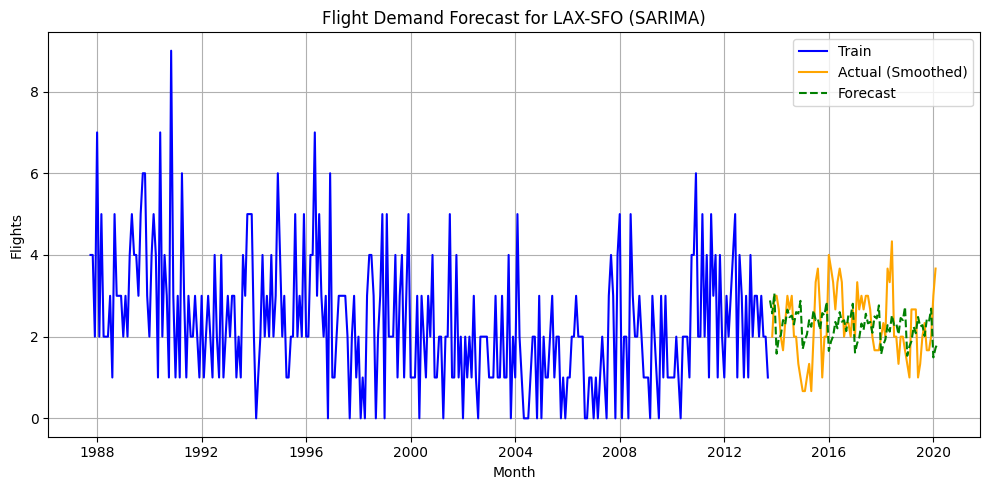

📈 Forecast Evaluation for LAX-SFO:
   RMSE : 1.62
   MAE  : 1.29
   R²   : -0.10


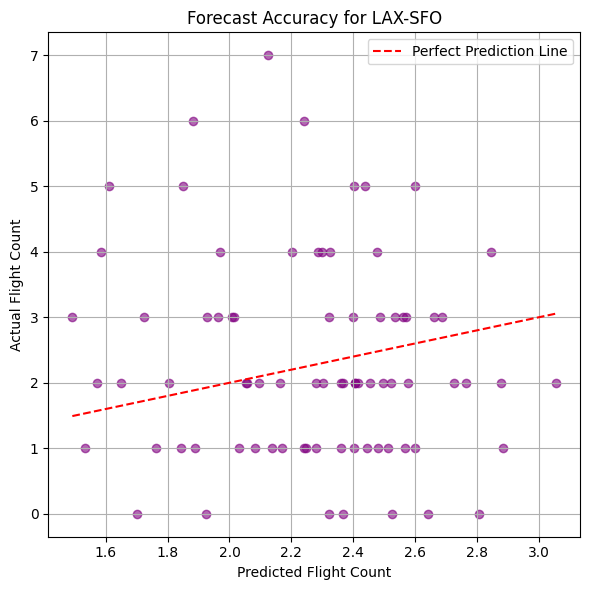

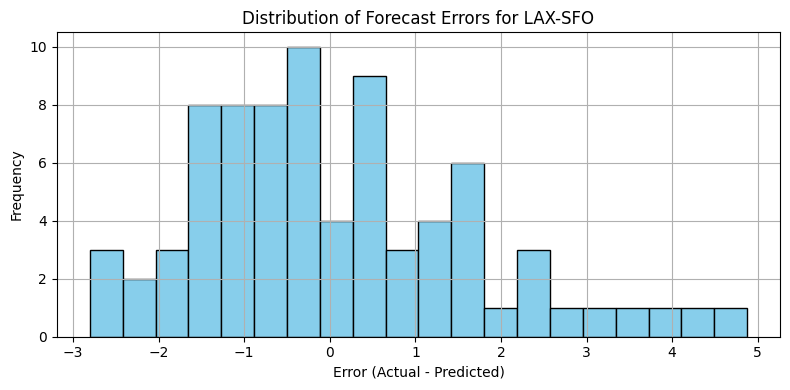

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

print("--- Starting Q4: Time-Series Forecasting with SARIMA...")

# Load dataset
df = pd.read_csv("airline_2m.csv", encoding="ISO-8859-1", parse_dates=["FlightDate"])

# Create Route and Month columns
df["Route"] = df["Origin"].str.strip().str.upper() + "-" + df["Dest"].str.strip().str.upper()
df["Month"] = df["FlightDate"].dt.to_period("M")

# Group by route and month
route_monthly = df.groupby(["Route", "Month"]).size().reset_index(name="FlightCount")
route_monthly["Month"] = route_monthly["Month"].dt.to_timestamp()

# Manually select 3 routes (including JFK-LAX)
top_routes = ["JFK-LAX"]
value_counts = df["Route"].value_counts().index.tolist()
for route in value_counts:
    if route not in top_routes:
        top_routes.append(route)
    if len(top_routes) == 3:
        break
print("✈️ Selected Routes:", top_routes)

# Forecast for each route
for route in top_routes:
    print(f"\n📈 Processing route: {route}")
    data = route_monthly[route_monthly["Route"] == route].sort_values("Month")
    data.set_index("Month", inplace=True)

    # Fill missing months with 0
    full_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq="MS")
    data = data.reindex(full_range).fillna(0)
    data.index.name = "Month"

    # Train/test split (80/20)
    split_idx = int(len(data) * 0.8)
    train, test = data.iloc[:split_idx], data.iloc[split_idx:]

    # Fit SARIMA model (p,d,q)x(P,D,Q,12) — adjust if needed
    model = SARIMAX(train["FlightCount"],
                    order=(1, 1, 1),
                    seasonal_order=(1, 1, 1, 12),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)

    # Forecast
    forecast = results.get_forecast(steps=len(test))
    forecast_values = forecast.predicted_mean
    test["Forecast"] = forecast_values

    # Smooth actual values for better plotting
    test["SmoothedActual"] = test["FlightCount"].rolling(window=3, center=True).mean()

    # Evaluate
    rmse = np.sqrt(mean_squared_error(test["FlightCount"], test["Forecast"]))
    print(f"📊 RMSE for {route}: {rmse:.2f} (lower is better)")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(train.index, train["FlightCount"], label="Train", color="blue")
    plt.plot(test.index, test["SmoothedActual"], label="Actual (Smoothed)", color="orange")
    plt.plot(test.index, test["Forecast"], label="Forecast", color="green", linestyle="--")
    plt.title(f"Flight Demand Forecast for {route} (SARIMA)")
    plt.xlabel("Month")
    plt.ylabel("Flights")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Additional performance metrics
mae = mean_absolute_error(test["FlightCount"], test["Forecast"])
r2 = r2_score(test["FlightCount"], test["Forecast"])

print(f"📈 Forecast Evaluation for {route}:")
print(f"   RMSE : {rmse:.2f}")
print(f"   MAE  : {mae:.2f}")
print(f"   R²   : {r2:.2f}")

# Plot: Forecast vs Actual (Scatter for Accuracy)
plt.figure(figsize=(6, 6))
plt.scatter(test["Forecast"], test["FlightCount"], color="purple", alpha=0.6)
plt.plot([test["Forecast"].min(), test["Forecast"].max()],
         [test["Forecast"].min(), test["Forecast"].max()],
         'r--', label="Perfect Prediction Line")

plt.xlabel("Predicted Flight Count")
plt.ylabel("Actual Flight Count")
plt.title(f"Forecast Accuracy for {route}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot: Histogram of Forecast Errors
errors = test["FlightCount"] - test["Forecast"]

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=20, color="skyblue", edgecolor="black")
plt.title(f"Distribution of Forecast Errors for {route}")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()